In [ ]:
## Importing the necessary packages
import numpy as np
import pandas as pd
import scipy.stats as scs
import re
from numpy import genfromtxt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D,LSTM, BatchNormalization, MaxPooling1D, MaxPooling2D,Reshape
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from scipy import signal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Shareddrives/EE147

Mounted at /content/drive
/content/drive/Shareddrives/EE147


## Loading the dataset and creating the train, val and test sets

In [ ]:
## Loading the dataset

## Loading the numpy arrays
dir = '/content/drive/Shareddrives/EE147/project_data/'
X_test = np.load(dir+"X_test.npy")
y_test = np.load(dir+"y_test.npy")
person_train_valid = np.load(dir+"person_train_valid.npy")
X_train_valid = np.load(dir+"X_train_valid.npy")
y_train_valid = np.load(dir+"y_train_valid.npy")
person_test = np.load(dir+"person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [ ]:
# random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)

x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)

x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
y_test = to_categorical(y_test, 4)

print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)
print (x_valid.shape)
print (y_valid.shape)

(1615, 1000, 1, 22)
(1615, 4)
(443, 1000, 1, 22)
(443, 4)
(500, 1000, 1, 22)
(500, 4)


# CNN-LSTM Model

In [ ]:
# Model parameters
dropout = 0.5
learning_rate = 1e-3
epochs = 100

#Building the model

cnn_lstm_model = Sequential()

# First block of conv.
cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(1000,1,22)))
cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_lstm_model.add(BatchNormalization())
cnn_lstm_model.add(Dropout(dropout))

# Second block of conv.
cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_lstm_model.add(BatchNormalization())
cnn_lstm_model.add(Dropout(dropout))

# Third block of conv.
cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_lstm_model.add(BatchNormalization())
cnn_lstm_model.add(Dropout(dropout))

# FC+LSTM layer
cnn_lstm_model.add(Flatten())
cnn_lstm_model.add(Dense((50)))
cnn_lstm_model.add(Reshape((50,1)))
cnn_lstm_model.add(LSTM(10, dropout=0.5, recurrent_dropout=0.5, input_shape=(50,1), return_sequences=False))

# FC layer
cnn_lstm_model.add(Dense(4, activation='softmax'))

# Defining the optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Printing the model summary
cnn_lstm_model.summary()

# Training and validating the model

cnn_lstm_results = cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 1000, 1, 25)       5525      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 334, 1, 25)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 334, 1, 25)        100       
_________________________________________________________________
dropout_8 (Dropout)          (None, 334, 1, 25)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 334, 1, 50)        12550     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 1, 50)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 112, 1, 50)       

Epoch 40/100
26/26 [==============================] - 3s 135ms/step - loss: 0.8864 - accuracy: 0.6303 - val_loss: 1.2396 - val_accuracy: 0.5080
Epoch 41/100
26/26 [==============================] - 4s 140ms/step - loss: 0.9212 - accuracy: 0.6033 - val_loss: 1.3222 - val_accuracy: 0.4740
Epoch 42/100
26/26 [==============================] - 4s 172ms/step - loss: 0.8737 - accuracy: 0.6386 - val_loss: 1.3323 - val_accuracy: 0.4580
Epoch 43/100
26/26 [==============================] - 4s 162ms/step - loss: 0.8526 - accuracy: 0.6598 - val_loss: 1.3263 - val_accuracy: 0.4820
Epoch 44/100
26/26 [==============================] - 4s 156ms/step - loss: 0.8745 - accuracy: 0.6330 - val_loss: 1.2756 - val_accuracy: 0.5040
Epoch 45/100
26/26 [==============================] - 4s 150ms/step - loss: 0.8892 - accuracy: 0.6191 - val_loss: 1.2517 - val_accuracy: 0.5100
Epoch 46/100
26/26 [==============================] - 4s 159ms/step - loss: 0.8661 - accuracy: 0.6293 - val_loss: 1.2230 - val_accuracy:

Epoch 97/100
26/26 [==============================] - 4s 151ms/step - loss: 0.5861 - accuracy: 0.7704 - val_loss: 1.3590 - val_accuracy: 0.5440
Epoch 98/100
26/26 [==============================] - 4s 155ms/step - loss: 0.5464 - accuracy: 0.8036 - val_loss: 1.4238 - val_accuracy: 0.5200
Epoch 99/100
26/26 [==============================] - 4s 163ms/step - loss: 0.5647 - accuracy: 0.7891 - val_loss: 1.4846 - val_accuracy: 0.5400
Epoch 100/100
26/26 [==============================] - 5s 178ms/step - loss: 0.5809 - accuracy: 0.7807 - val_loss: 1.5340 - val_accuracy: 0.5060


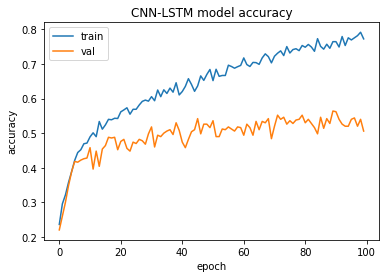

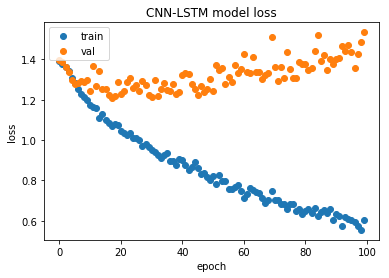

In [ ]:
import matplotlib.pyplot as plt

# list all data in history
#print(history.history.keys())

# summarize history for accuracy
plt.plot(cnn_lstm_results.history['accuracy'])
plt.plot(cnn_lstm_results.history['val_accuracy'])
plt.title('CNN-LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(cnn_lstm_results.history['loss'],'o')
plt.plot(cnn_lstm_results.history['val_loss'],'o')
plt.title('CNN-LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the CNN-LSTM model

score = cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the CNN-LSTM model:',score[1])

Test accuracy of the CNN-LSTM model: 0.544018030166626
